In [158]:
## Importing the Libraries 
import os
import nsepy as nse
import talib as ta
import pandas as pd
import io
import requests
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')

In [159]:
## Function for definition of BUY and SELL based on RSI 
def rsi_20_80(x):
    if(x<20):
        return "BUY"
    elif(x>80):
        return "SELL"
    else:
        return "NO SIGNAL"

In [160]:
## Extracting names of the companies in Nifty 50 
url = 'https://www.nseindia.com/content/indices/ind_nifty50list.csv'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))
company_symbols=list(df['Symbol'].values)
print(company_symbols)

['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJFINANCE', 'BAJAJFINSV', 'BPCL', 'BHARTIARTL', 'INFRATEL', 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'HDFC', 'ICICIBANK', 'ITC', 'IBULHSGFIN', 'IOC', 'INDUSINDBK', 'INFY', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M', 'MARUTI', 'NTPC', 'ONGC', 'POWERGRID', 'RELIANCE', 'SBIN', 'SUNPHARMA', 'TCS', 'TATAMOTORS', 'TATASTEEL', 'TECHM', 'TITAN', 'UPL', 'ULTRACEMCO', 'VEDL', 'WIPRO', 'YESBANK', 'ZEEL']


In [161]:
## Constructing a Dictionary in which each element of a dictionary is a DataFrame 
data={}
for s in company_symbols:
    print(s)
    data[s]=nse.get_history(s,start=date(2018,1,1),end=date.today())

ADANIPORTS
ASIANPAINT
AXISBANK
BAJAJ-AUTO
BAJFINANCE
BAJAJFINSV
BPCL
BHARTIARTL
INFRATEL
BRITANNIA
CIPLA
COALINDIA
DRREDDY
EICHERMOT
GAIL
GRASIM
HCLTECH
HDFCBANK
HEROMOTOCO
HINDALCO
HINDUNILVR
HDFC
ICICIBANK
ITC
IBULHSGFIN
IOC
INDUSINDBK
INFY
JSWSTEEL
KOTAKBANK
LT
M&M
MARUTI
NTPC
ONGC
POWERGRID
RELIANCE
SBIN
SUNPHARMA
TCS
TATAMOTORS
TATASTEEL
TECHM
TITAN
UPL
ULTRACEMCO
VEDL
WIPRO
YESBANK
ZEEL


In [162]:
## Adding New column of Technical indicators 
for key in company_symbols:
    data[key]['ADX']=ta.ADX(data[key].High,data[key].Low,data[key].Close,timeperiod=14)
    data[key]['RSI_9']=ta.RSI(data[key].Close,timeperiod=9)
    data[key]['RSI_14']=ta.RSI(data[key].Close,timeperiod=14)
    data[key]['STOCH_skowk'],data[key]['STOCH_slowd'] = ta.STOCH(data[key].High,data[key].Low,data[key].Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    data[key]['WILLR']=ta.WILLR(data[key].High,data[key].Low,data[key].Close, timeperiod=14)
    data[key]['MA_20']=ta.MA(data[key].Close, timeperiod=20, matype=0)
    data[key]['MA_50']=ta.MA(data[key].Close, timeperiod=50, matype=0)
    data[key]['MA_100']=ta.MA(data[key].Close, timeperiod=100, matype=0)
    data[key]['EMA_8']=ta.EMA(data[key].Close, timeperiod=8)
    data[key]['ADX+DMI']=data[key]['ADX']+ta.DX(data[key].High,data[key].Low,data[key].Close,timeperiod=14)
    data[key]['ADX-DMI']=data[key]['ADX']-ta.DX(data[key].High,data[key].Low,data[key].Close,timeperiod=14)
    data[key]['SMA_20']=ta.SMA(data[key].Close, timeperiod=20)
    data[key]['SMA_50']=ta.SMA(data[key].Close, timeperiod=50)
    data[key]['SMA20_cross_SMA50']=data[key]['SMA_20']>data[key]['SMA_50']
    data[key]['SMA20_cross_SMA50']=data[key]['SMA20_cross_SMA50'].apply(lambda x:'BUY' if x==True else "NO SIGNAL")
    data[key]['RSI_9(20_80)']=data[key]['RSI_9'].apply(lambda x: rsi_20_80(x))
    data[key]['RSI_14(20_80)']=data[key]['RSI_14'].apply(lambda x: rsi_20_80(x))   

In [163]:
## Creating a New Dataframe and dropping NA values caused due to creating indicators
data_new=data.copy()
for key in company_symbols:
    data_new[key]=data_new[key].dropna()

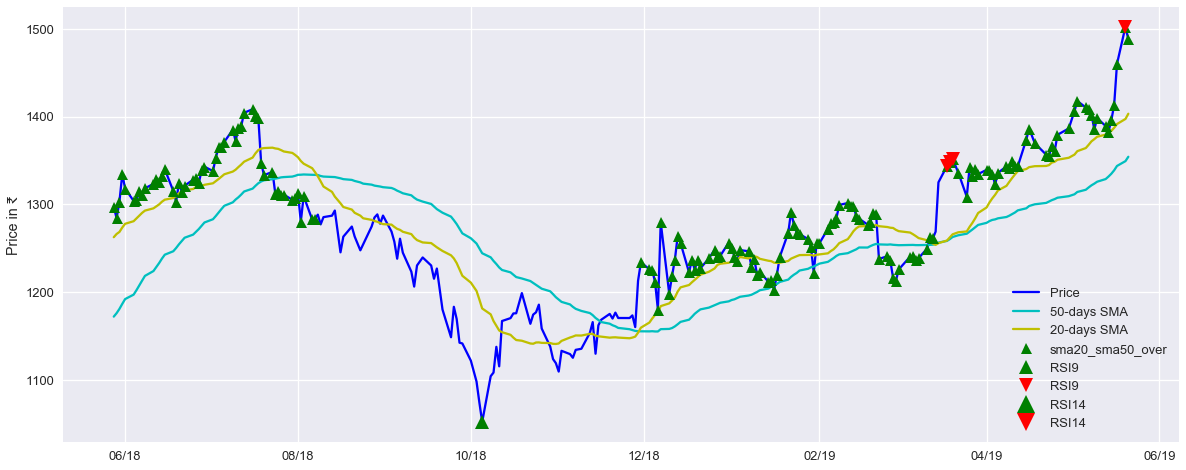

In [164]:
## Plot for Checking graph indivisually 
company='KOTAKBANK'
start_date = data_new[company].index.min()
end_date = data_new[company].index.max()

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(data_new[company].loc[start_date:end_date, :].index, data_new[company].loc[start_date:end_date,'Close'],color='b',label='Price',)
ax.plot(data_new[company]['SMA_50'].index,data_new[company]['SMA_50'].values,color='c',label = '50-days SMA')
ax.plot(data_new[company]['SMA_20'].index,data_new[company]['SMA_20'].values,color='y',label = '20-days SMA')
## Recommend Based on SMA20 and SMA50 Crossover
buy = data_new[company].loc[data_new[company]['SMA20_cross_SMA50']=='BUY']
plt.plot(buy.index, data[company].loc[buy.index]['Close'], '^', markersize=11, color='g',label='sma20_sma50_over')

## Recommend Based on RSI_9 (BUY <20 and SELL >80)
buy1=data_new[company].loc[data_new[company]['RSI_9(20_80)']=='BUY']
sell1=data_new[company].loc[data_new[company]['RSI_9(20_80)']=='SELL']
plt.plot(buy1.index, data[company].loc[buy1.index]['Close'], '^', markersize=14, color='g',label='RSI9')
plt.plot(sell1.index, data[company].loc[sell1.index]['Close'], 'v', markersize=14, color='r',label='RSI9')

## Recommend Based on RSI_14 (BUY <20 and SELL >80)
buy2=data_new[company].loc[data_new[company]['RSI_14(20_80)']=='BUY']
sell2=data_new[company].loc[data_new[company]['RSI_14(20_80)']=='SELL']
plt.plot(buy2.index, data[company].loc[buy2.index]['Close'], '^', markersize=18, color='g',label='RSI14')
plt.plot(sell2.index, data[company].loc[sell2.index]['Close'], 'v', markersize=18, color='r',label='RSI14')

ax.plot()
ax.legend(loc='best')
ax.set_ylabel('Price in ₹')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [165]:
## For Saving all figures into png picture 
print(os.getcwd())
os.chdir('C:\\Users\\raghu\\Technical_Analysis\\Technical_Charts\\')
print(os.getcwd())
for var in company_symbols:
    company=var
    start_date = data_new[company].index.min()
    end_date = data_new[company].index.max()

    fig, ax = plt.subplots(figsize=(20,8))

    ax.plot(data_new[company].loc[start_date:end_date, :].index, data_new[company].loc[start_date:end_date,'Close'],color='b',label='Price',)
    ax.plot(data_new[company]['SMA_50'].index,data_new[company]['SMA_50'].values,color='c',label = '50-days SMA')
    ax.plot(data_new[company]['SMA_20'].index,data_new[company]['SMA_20'].values,color='y',label = '20-days SMA')
    ## Recommend Based on SMA20 and SMA50 Crossover
    buy = data_new[company].loc[data_new[company]['SMA20_cross_SMA50']=='BUY']
    plt.plot(buy.index, data[company].loc[buy.index]['Close'], '^', markersize=11, color='g',label='sma20_sma50_over')

    ## Recommend Based on RSI_9 (BUY <20 and SELL >80)
    buy1=data_new[company].loc[data_new[company]['RSI_9(20_80)']=='BUY']
    sell1=data_new[company].loc[data_new[company]['RSI_9(20_80)']=='SELL']
    plt.plot(buy1.index, data[company].loc[buy1.index]['Close'], '^', markersize=14, color='g',label='RSI9')
    plt.plot(sell1.index, data[company].loc[sell1.index]['Close'], 'v', markersize=14, color='r',label='RSI9')

    ## Recommend Based on RSI_14 (BUY <20 and SELL >80)
    buy2=data_new[company].loc[data_new[company]['RSI_14(20_80)']=='BUY']
    sell2=data_new[company].loc[data_new[company]['RSI_14(20_80)']=='SELL']
    plt.plot(buy2.index, data[company].loc[buy2.index]['Close'], '^', markersize=18, color='g',label='RSI14')
    plt.plot(sell2.index, data[company].loc[sell2.index]['Close'], 'v', markersize=18, color='r',label='RSI14')

    ax.plot()
    ax.legend(loc='best')
    ax.set_ylabel('Price in ₹')
    ax.xaxis.set_major_formatter(my_year_month_fmt)
    plt.savefig(company+".png")
    plt.close()
    print(company)

C:\Users\raghu
C:\Users\raghu\Technical_Analysis\Technical_Charts
ADANIPORTS
ASIANPAINT
AXISBANK
BAJAJ-AUTO
BAJFINANCE
BAJAJFINSV
BPCL
BHARTIARTL
INFRATEL
BRITANNIA
CIPLA
COALINDIA
DRREDDY
EICHERMOT
GAIL
GRASIM
HCLTECH
HDFCBANK
HEROMOTOCO
HINDALCO
HINDUNILVR
HDFC
ICICIBANK
ITC
IBULHSGFIN
IOC
INDUSINDBK
INFY
JSWSTEEL
KOTAKBANK
LT
M&M
MARUTI
NTPC
ONGC
POWERGRID
RELIANCE
SBIN
SUNPHARMA
TCS
TATAMOTORS
TATASTEEL
TECHM
TITAN
UPL
ULTRACEMCO
VEDL
WIPRO
YESBANK
ZEEL


In [166]:
## Creating a New Dataframe and removing all column except O,H,L,V and Indicators and Combining into new DataFrame and saving as csv
data_for_csv=data_new.copy()
for key in company_symbols:
    data_for_csv[key]=data_for_csv[key].drop(['Symbol','Series','Prev Close','Last','VWAP','Turnover', 'Trades', 'Deliverable Volume','%Deliverble','Volume'],axis=1)

data_combined=pd.concat(data_for_csv,axis=1)
os.chdir('C:\\Users\\raghu\\Technical_Analysis\\')
data_combined.to_csv("Data_Combined_Nifty_50.csv")
data_combined.head()

ADANIPORTS                                                \
                 Open    High     Low   Close        ADX      RSI_9   
Date                                                                  
2018-05-28      382.5  383.45  376.20  378.90  26.855000  35.464924   
2018-05-29      379.8  383.85  373.20  377.85  28.111197  34.453483   
2018-05-30      374.0  378.95  370.00  374.40  29.503660  31.167773   
2018-05-31      375.5  397.60  369.25  392.15  28.020476  55.648935   
2018-06-01      394.1  395.40  382.30  387.60  26.643233  50.472177   

                                                              ...       \
               RSI_14 STOCH_skowk STOCH_slowd      WILLR      ...        
Date                                                          ...        
2018-05-28  39.995979   44.370123   26.562007 -71.936759      ...        
2018-05-29  39.301261   60.520909   43.534554 -73.594378      ...        
2018-05-30  37.025595   59.212457   54.701163 -80.522088      ...        
2018-05-31  52.321856   67.265678   62.333014 -44.320487      ...        
2018-06-01  49.033975   65.951752   64.143296 -51.585624      ...        

               ZEEL                                                        \
              MA_50    MA_100       EMA_8    ADX+DMI    ADX-DMI    SMA_20   
Date                                                                        
2018-05-28  578.506  580.3015  566.133385  22.247749   9.522915  578.0850   
2018-05-29  578.244  580.0825  564.170410  21.567541   8.842707  576.5475   
2018-05-30  577.986  579.8755  562.676986  16.835600  11.764695  574.6050   
2018-05-31  577.778  579.6385  561.204322  17.817469   9.345116  572.7175   
2018-06-01  577.442  579.4215  560.558917  17.149961   8.677608  571.3000   

                                                                  
             SMA_50 SMA20_cross_SMA50 RSI_9(20_80) RSI_14(20_80)  
Date                                                              
2018-05-28  578.506         NO SIGNAL    NO SIGNAL     NO SIGNAL  
2018-05-29  578.244         NO SIGNAL    NO SIGNAL     NO SIGNAL  
2018-05-30  577.986         NO SIGNAL    NO SIGNAL     NO SIGNAL  
2018-05-31  577.778         NO SIGNAL    NO SIGNAL     NO SIGNAL  
2018-06-01  577.442         NO SIGNAL    NO SIGNAL     NO SIGNAL  

[5 rows x 1050 columns]

In [167]:
### Saving Indivisual Data with all column with Missing/Na values also 
os.chdir('C:\\Users\\raghu\\Technical_Analysis\\\Indivisual_Data_With_NA\\')
for key in company_symbols:
    data[key].to_csv(key+".csv")
### Saving Indivisual Data with all column after dropping NA values 
os.chdir('C:\\Users\\raghu\\Technical_Analysis\\\Indivisual_Data_Without_NA\\')
for key in company_symbols:
    data_new[key].to_csv(key+".csv")
## Changing Directory Back 
os.chdir('C:\\Users\\raghu\\')